In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Dataset visualization

## Returns of each stock

In [3]:
import sys
import os

# Получаем путь к директории текущего скрипта
current_dir = os.getcwd()

# Получаем путь к директории, на уровень выше
parent_dir = os.path.dirname(current_dir)

# Добавляем путь к родительской директории в sys.path
sys.path.append(parent_dir)

# from library.dataset import get_prices, get_log_returns

In [4]:
from library.dataset import get_prices, get_log_returns

# Load returns
df_returns_real = get_log_returns(get_prices())
tickers = df_returns_real.columns

Chosen tickers: ['SBER', 'LKOH', 'SBERP', 'VTBR', 'MOEX']
Length before dropping NaNs: 2986
Length after dropping NaNs: 2956


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
!conda create -n myenv python=3.11 --y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/nikolajgudkov/opt/anaconda3/envs/myenv

  added / updated specs:
    - python=3.11


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bzip2-1.0.8                |       h6c40b1e_6         151 KB
    ca-certificates-2024.12.31 |       hecd8cb5_0         129 KB
    libffi-3.4.4               |       hecd8cb5_1         129 KB
    ncurses-6.4                |       hcec6c5f_0        1018 KB
    openssl-3.0.15             |       h46256e1_0         4.5 MB
    pip-24.2                   |  py311hecd8cb5_0         2.8 MB
    python-3.11.11             |       h4d6d9e5_0        15.7 MB
    readline-8.2               |       hca72f7f_0      

In [15]:
!conda init bash

no change     /Users/nikolajgudkov/opt/anaconda3/condabin/conda
no change     /Users/nikolajgudkov/opt/anaconda3/bin/conda
no change     /Users/nikolajgudkov/opt/anaconda3/bin/conda-env
no change     /Users/nikolajgudkov/opt/anaconda3/bin/activate
no change     /Users/nikolajgudkov/opt/anaconda3/bin/deactivate
no change     /Users/nikolajgudkov/opt/anaconda3/etc/profile.d/conda.sh
no change     /Users/nikolajgudkov/opt/anaconda3/etc/fish/conf.d/conda.fish
no change     /Users/nikolajgudkov/opt/anaconda3/shell/condabin/Conda.psm1
no change     /Users/nikolajgudkov/opt/anaconda3/shell/condabin/conda-hook.ps1
no change     /Users/nikolajgudkov/opt/anaconda3/lib/python3.9/site-packages/xontrib/conda.xsh
no change     /Users/nikolajgudkov/opt/anaconda3/etc/profile.d/conda.csh
no change     /Users/nikolajgudkov/.bash_profile
No action taken.


In [18]:
!exit

In [19]:
!conda activate myenv


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [21]:
!python --version

Python 3.9.7


In [6]:
from library.portfolio import plot_tickers_performance

plot_tickers_performance(df_returns_real)

TypeError: unsupported operand type(s) for |: 'type' and 'type'

## Returns correlation matrix

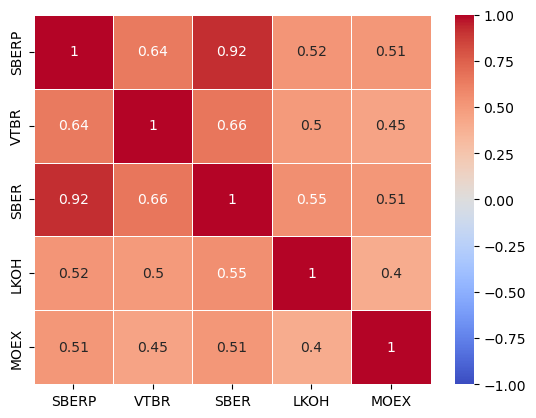

In [5]:
from library.correlations import plot_correlation_matrix

sorted_tickers = plot_correlation_matrix(df_returns_real.corr())

# Generated returns test

In [9]:
from library.gan_train_loop import load_gan
from library.gan import Generator
from library.constants import DEVICE

generator = Generator().to(DEVICE)
load_gan('TCN', generator, epoch=800)

Load 800 epoch checkpoint


In [61]:
from library.generation import generate_fake_returns

df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

N_RETURNS_FAKE_DATASETS = 100

df_returns_fake_list = [generate_fake_returns(generator, df_returns_real, seed=i) for i in tqdm(range(N_RETURNS_FAKE_DATASETS))]

  0%|          | 0/100 [00:00<?, ?it/s]

## Equal portfolio on real and fake samples

In [83]:
from library.portfolio import get_returns, print_statistics, plot_cumulative_returns
from library.momentum import get_equal_portfolio

w = get_equal_portfolio(df_returns_real.columns)

equal_w_real_returns = get_returns(w, df_returns_real)
equal_w_fake_returns = get_returns(w, df_returns_fake)

print('Real:')
print_statistics(equal_w_real_returns)
print('\nFake:')
print_statistics(equal_w_fake_returns)

Real:
Annual Return (mean ± std): 6.7% ± 27.3%
Sharpe: 0.24
Annual Mean Return 95% confidence interval: 6.66%±16.74%

Fake:
Annual Return (mean ± std): 6.5% ± 25.9%
Sharpe: 0.25
Annual Mean Return 95% confidence interval: 6.51%±15.87%


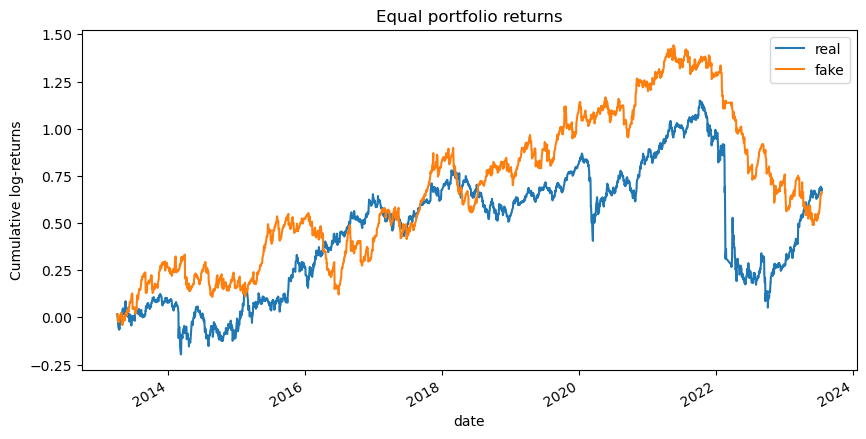

In [88]:
def plot_strategy_on_both_returns(real_returns: pd.Series, fake_returns: pd.Series, title: str):
    plt.figure(figsize=(10, 5))

    real_returns.cumsum().plot(ax=plt.gca(), label='real')
    fake_returns.cumsum().plot(ax=plt.gca(), label='fake')
    plt.title(title)
    plt.ylabel('Cumulative log-returns')
    plt.legend()


plot_strategy_on_both_returns(equal_w_real_returns, equal_w_fake_returns, 'Equal portfolio returns')

# Momentum portfolio on real and fake samples

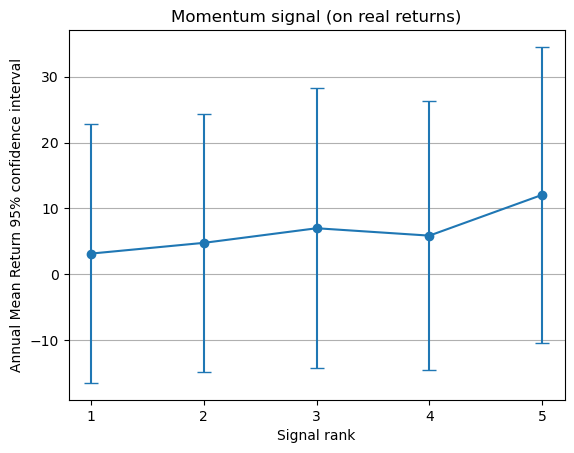

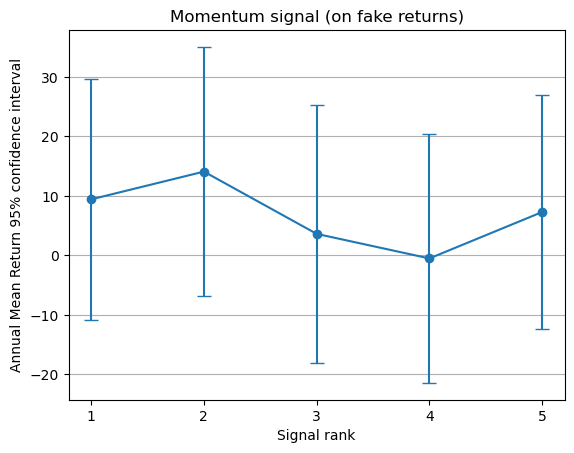

In [188]:
from library.momentum import get_momentum_signal, plot_signal_ranks


def get_momentum_signal_fixed_params(df_returns: pd.DataFrame) -> pd.DataFrame:
    return get_momentum_signal(df_returns, n_finish=365, n_start=180)


def plot_momentum_signal_ranks(df_returns, title: str):
    df_momentum_signal = get_momentum_signal_fixed_params(df_returns)
    plot_signal_ranks(df_momentum_signal, df_returns, f'Momentum signal (on {title} returns)')


plot_momentum_signal_ranks(df_returns_real, 'real')
plot_momentum_signal_ranks(df_returns_fake, 'fake')

Real:
Annual Return (mean ± std): 7.8% ± 29.8%
Sharpe: 0.26
Annual Mean Return 95% confidence interval: 7.85%±18.36%

Fake:
Annual Return (mean ± std): 4.3% ± 27.0%
Sharpe: 0.16
Annual Mean Return 95% confidence interval: 4.32%±16.61%


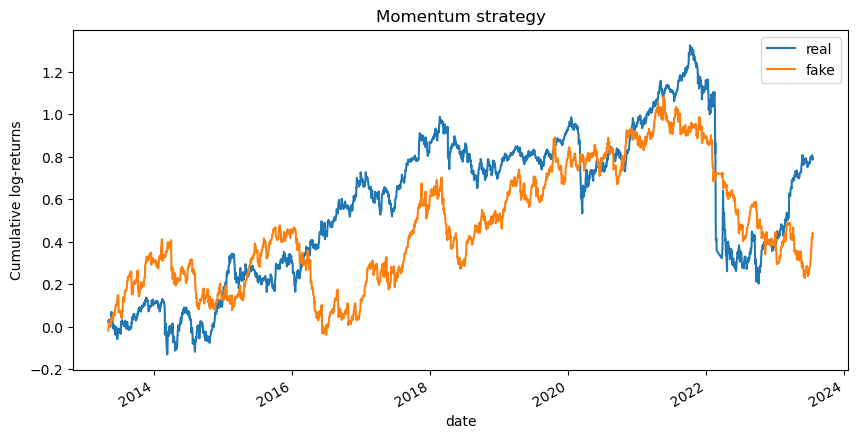

In [189]:
from library.momentum import get_portfolio_from_signal


def get_momentum_signal_returns(df_returns: pd.DataFrame):
    df_momentum_signal = get_momentum_signal_fixed_params(df_returns)
    df_momentum_weights = get_portfolio_from_signal(df_momentum_signal)
    return get_returns(df_momentum_weights, df_returns)


momentum_returns_real = get_momentum_signal_returns(df_returns_real)
momentum_returns_fake = get_momentum_signal_returns(df_returns_fake)

print('Real:')
print_statistics(momentum_returns_real)

print('\nFake:')
print_statistics(momentum_returns_fake)

plot_strategy_on_both_returns(momentum_returns_real, momentum_returns_fake, 'Momentum strategy')

# Momentum portfolio on 100 fake samples

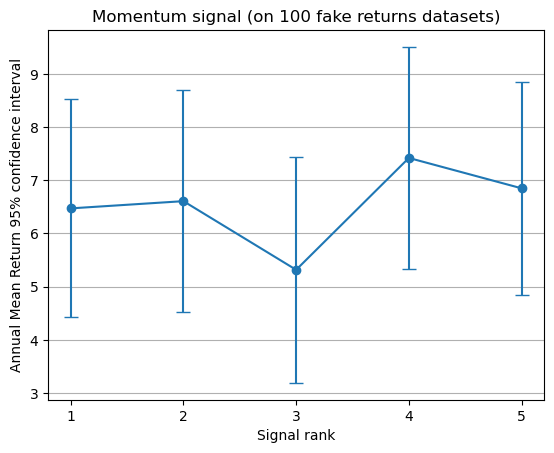

In [190]:
def plot_momentum_signal_ranks_list(df_returns_fake_list: list[pd.DataFrame]):
    df_momentum_signal_list = [get_momentum_signal_fixed_params(df_returns).reset_index(drop=True) for df_returns in df_returns_fake_list]
    df_momentum_signal = pd.concat(df_momentum_signal_list, axis=0).reset_index(drop=True)
    df_returns_fake = pd.concat(df_returns_fake_list, axis=0).reset_index(drop=True)
    plot_signal_ranks(df_momentum_signal, df_returns_fake, f'Momentum signal (on {N_RETURNS_FAKE_DATASETS} fake returns datasets)')


plot_momentum_signal_ranks_list(df_returns_fake_list)

# Momentum and equal portfolio returns on 100 fake samples

In [107]:
momentum_returns_fake_list = pd.concat([get_momentum_signal_returns(df_returns) for df_returns in df_returns_fake_list], axis=0).reset_index(drop=True)
equal_returns_fake_list = get_returns(get_equal_portfolio(df_returns_real.columns), pd.concat(df_returns_fake_list, axis=0).reset_index(drop=True))
print(f'Momentum (on {N_RETURNS_FAKE_DATASETS} fake returns datasets)')
print_statistics(momentum_returns_fake_list)
print(f'\nEqual (on {N_RETURNS_FAKE_DATASETS} fake returns datasets)')
print_statistics(equal_returns_fake_list)

Momentum (on 100 fake returns datasets)
Annual Return (mean ± std): 6.7% ± 26.8%
Sharpe: 0.25
Annual Mean Return 95% confidence interval: 6.71%±1.65%

Equal (on 100 fake returns datasets)
Annual Return (mean ± std): 6.5% ± 25.7%
Sharpe: 0.25
Annual Mean Return 95% confidence interval: 6.55%±1.58%


# Momentum hyperparameter tuning

In [117]:
from library.portfolio import get_statistics, Statistics


def get_momentum_signal_with_params(df_returns: pd.DataFrame, n_finish: int, n_start: int) -> pd.DataFrame:
    df_momentum_signal = get_momentum_signal(df_returns, n_finish=n_finish, n_start=n_start)
    df_momentum_weights = get_portfolio_from_signal(df_momentum_signal)
    return get_returns(df_momentum_weights, df_returns)


def get_momentum_signal_statistics_with_params_list(df_returns_list: list[pd.DataFrame], n_finish: int, n_start: int) -> Statistics:
    df_returns = pd.concat([get_momentum_signal_with_params(df_returns, n_finish=n_finish, n_start=n_start) for df_returns in df_returns_list], axis=0).reset_index(drop=True)
    return get_statistics(df_returns)

In [122]:
N_START_VALUES = [20, 40, 60, 80, 100]
N_FINISH_VALUES = [150, 200, 250, 300, 350, 400]

stats_fake_by_params: dict[tuple[int, int], Statistics] = {}

for n_start in tqdm(N_START_VALUES):
    for n_finish in N_FINISH_VALUES:
        stats_fake_by_params[n_start, n_finish] = get_momentum_signal_statistics_with_params_list(df_returns_fake_list[:10], n_finish=n_finish, n_start=n_start)

  0%|          | 0/5 [00:00<?, ?it/s]

In [169]:
assert len(stats_fake_by_params) == len(N_START_VALUES) * len(N_FINISH_VALUES)
heatmap_data_fake = [[stats_fake_by_params[n_start, n_finish] for n_finish in N_FINISH_VALUES] for n_start in N_START_VALUES]

In [178]:
heatmap_data_real = [[get_statistics(get_momentum_signal_with_params(df_returns_real, n_finish=n_finish, n_start=n_start)) for n_finish in N_FINISH_VALUES] for n_start in N_START_VALUES]

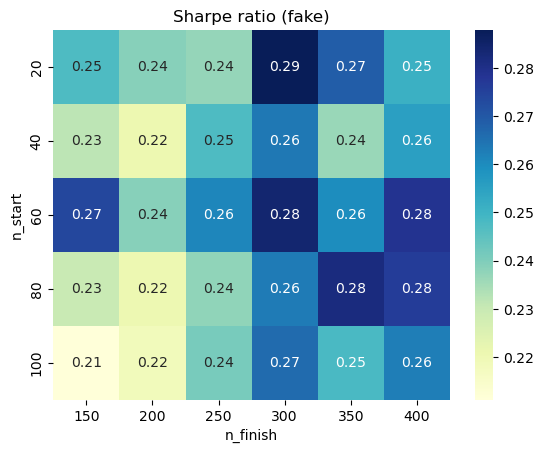

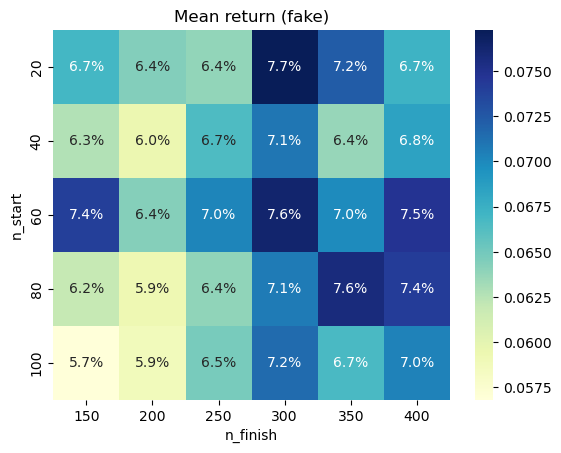

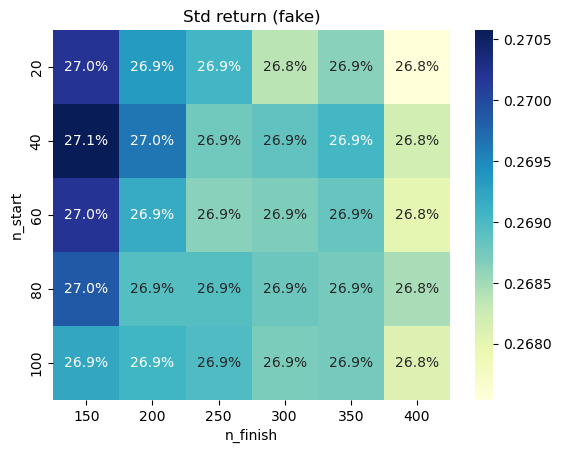

In [183]:
def plot_function(heatmap_data, func, title: str, fmt: str):
    sns.heatmap([[func(el) for el in row] for row in heatmap_data], annot=True, cmap='YlGnBu', fmt=fmt)

    plt.ylabel('n_start')
    plt.xlabel('n_finish')

    plt.yticks(np.arange(len(N_START_VALUES)) + 0.5, N_START_VALUES)
    plt.xticks(np.arange(len(N_FINISH_VALUES)) + 0.5, N_FINISH_VALUES)

    plt.title(title)
    plt.show()


plot_function(heatmap_data_fake, lambda x: x.sharpe_annual, 'Sharpe ratio (fake)', '.2f')
plot_function(heatmap_data_fake, lambda x: x.mean_return_annual, 'Mean return (fake)', '.1%')
plot_function(heatmap_data_fake, lambda x: x.std_return_annual, 'Std return (fake)', '.1%')

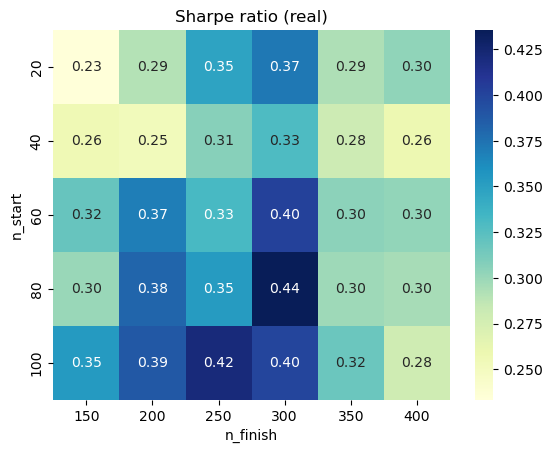

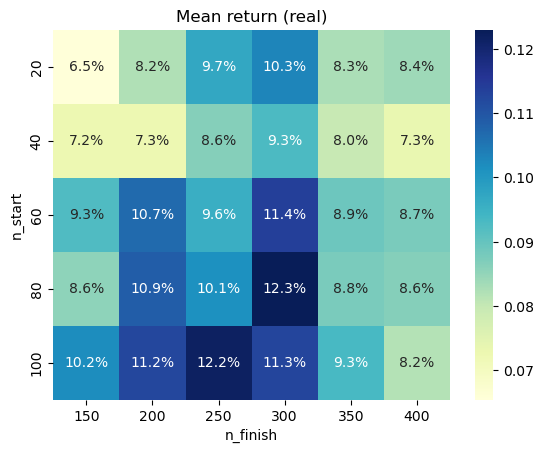

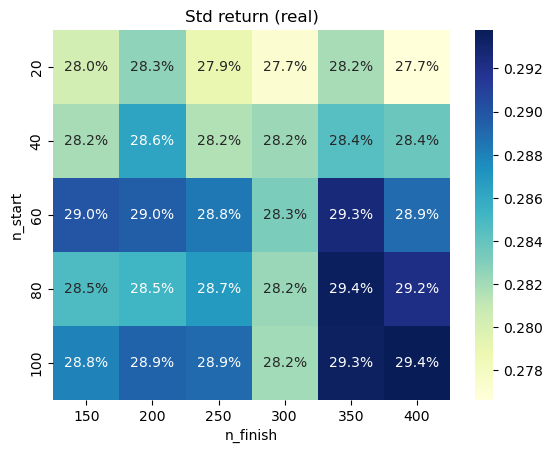

In [182]:
plot_function(heatmap_data_real, lambda x: x.sharpe_annual, 'Sharpe ratio (real)', '.2f')
plot_function(heatmap_data_real, lambda x: x.mean_return_annual, 'Mean return (real)', '.1%')
plot_function(heatmap_data_real, lambda x: x.std_return_annual, 'Std return (real)', '.1%')

In [185]:
N_START_OPTIMAL, N_FINISH_OPTIMAL = max(stats_fake_by_params, key=lambda k: stats_fake_by_params[k].sharpe_annual)
N_START_OPTIMAL, N_FINISH_OPTIMAL

(20, 300)

In [180]:
optimal_params_stat_fake = get_momentum_signal_statistics_with_params_list(df_returns_fake_list[10:], n_finish=N_FINISH_OPTIMAL, n_start=N_START_OPTIMAL)
optimal_params_stat_real = heatmap_data_real[N_START_VALUES.index(N_START_OPTIMAL)][N_FINISH_VALUES.index(N_FINISH_OPTIMAL)]

In [181]:
from library.constants import CONFIDENCE_INTERVAL

def print_stats(stats: Statistics):
    print(f'Annual Return (mean ± std): {stats.mean_return_annual:.1%} ± {stats.std_return_annual:.1%}')
    print(f'Sharpe: {stats.sharpe_annual:.2f}')
    print(f'Annual Mean Return {CONFIDENCE_INTERVAL:.0%} confidence interval: {stats.mean_return_annual:.2%}±{stats.mean_return_se_annual:.2%}')

print('Real:')
print_stats(optimal_params_stat_real)

print('\nFake:')
print_stats(optimal_params_stat_fake)

Real:
Annual Return (mean ± std): 10.3% ± 27.7%
Sharpe: 0.37
Annual Mean Return 95% confidence interval: 10.31%±17.12%

Fake:
Annual Return (mean ± std): 6.8% ± 26.8%
Sharpe: 0.25
Annual Mean Return 95% confidence interval: 6.76%±1.74%
